In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [3, 3]

In [2]:
device = 'cuda:7' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 3
BATCH_SIZE = 32
device


'cuda:7'

In [3]:
train_X = torch.load('./latent_datasets/diffusers/trainX_tensor.pt')
train_Y = torch.load('./latent_datasets/diffusers/trainY_tensor.pt')
val_X = torch.load('./latent_datasets/diffusers/valX_tensor.pt')
val_Y = torch.load('./latent_datasets/diffusers/valY_tensor.pt')

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_data = TensorDataset(train_X, train_Y)
val_data = TensorDataset(val_X,val_Y)

image_datasets = {'train' : train_data, 'val' : val_data}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}



print("Train dataset size --- ",len(train_data))
print("Val dataset size --- ",len(val_data))



Train dataset size ---  14630
Val dataset size ---  1500


In [5]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,1024)
        self.fc4 = nn.Linear(1024,NUM_CLASSES)
        self.act = nn.ReLU()

        self.dropout = nn.Dropout(0.6)

    def forward(self,x):
        # x = (b,1024)
        out = self.act(self.fc1(x))
        out = self.act(self.fc2(out))
        out = self.act(self.fc3(out))
        out = self.fc4(out) # (b,3)

        return out

In [6]:
import time
import copy
from torch.optim import lr_scheduler

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # keeps track of best_model for every epoch that performs better on val dataset
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Keep track of losses and accuracy in each epoch
    losses = {'train':[],'val':[]}
    acc = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            iter = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iter+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                #if phase == 'train' and iter%200 == 0:
                    #print(f'Iteration: {iter} Loss: {running_loss/(iter*BATCH_SIZE):.4f}')
            if phase == 'train':
                scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses,acc

In [42]:
model = MLP(input_size=16384).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model

MLP(
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=3, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
)

In [ ]:
model,loss,acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

In [7]:
ensemble = []
for i in range(100):
    model = {}
    model['architecture'] = MLP(input_size=16384).to(device)
    model['criterion'] = nn.CrossEntropyLoss()
    model['optimizer'] = torch.optim.Adam(model['architecture'].parameters(), lr=1e-3)
    model['lr_scheduler'] = lr_scheduler.StepLR(model['optimizer'], step_size=7, gamma=0.1)

    print('Iteration == ',i)
    model['architecture'],_,_ = train_model(model['architecture'], model['criterion'], model['optimizer'], model['lr_scheduler'],
                       num_epochs=10)
    ensemble.append(model)
    

Iteration ==  0
Epoch 0/9
----------
train Loss: 0.4852 Acc: 0.8099
val Loss: 0.3901 Acc: 0.8513

Epoch 1/9
----------
train Loss: 0.2095 Acc: 0.9249
val Loss: 0.4138 Acc: 0.8533

Epoch 2/9
----------
train Loss: 0.1155 Acc: 0.9586
val Loss: 0.5663 Acc: 0.8373

Epoch 3/9
----------
train Loss: 0.0825 Acc: 0.9719
val Loss: 0.5590 Acc: 0.8540

Epoch 4/9
----------
train Loss: 0.0707 Acc: 0.9784
val Loss: 0.5534 Acc: 0.8453

Epoch 5/9
----------
train Loss: 0.0557 Acc: 0.9846
val Loss: 0.6463 Acc: 0.8587

Epoch 6/9
----------
train Loss: 0.0424 Acc: 0.9867
val Loss: 0.7259 Acc: 0.8513

Epoch 7/9
----------
train Loss: 0.0129 Acc: 0.9962
val Loss: 0.7411 Acc: 0.8647

Epoch 8/9
----------
train Loss: 0.0018 Acc: 0.9997
val Loss: 0.8845 Acc: 0.8627

Epoch 9/9
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 1.0320 Acc: 0.8653

Training complete in 0m 31s
Best val Acc: 0.865333
Iteration ==  1
Epoch 0/9
----------
train Loss: 0.4800 Acc: 0.8131
val Loss: 0.4034 Acc: 0.8320

Epoch 1/9
-----

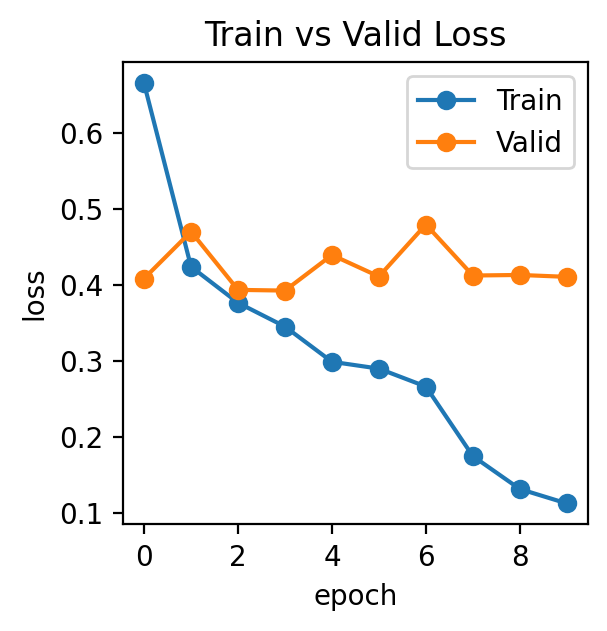

In [27]:
plt.plot(torch.tensor(loss['train']).numpy(),'-o')
plt.plot(torch.tensor(loss['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

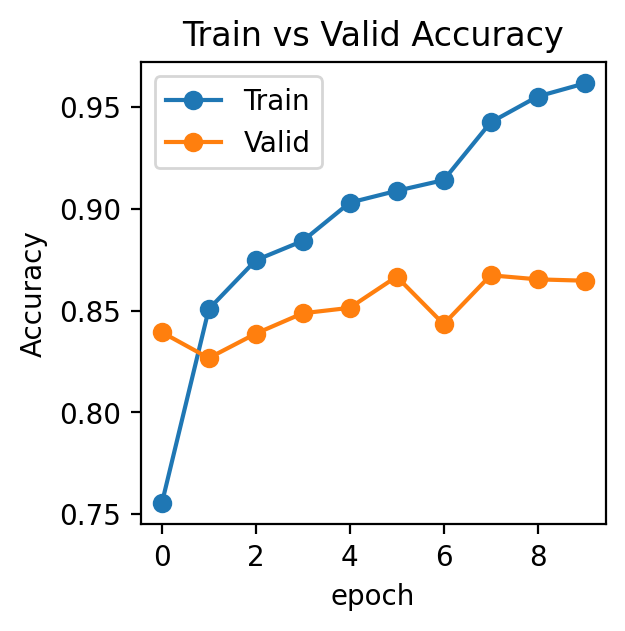

In [28]:
plt.plot(torch.tensor(acc['train']).numpy(),'-o')
plt.plot(torch.tensor(acc['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [29]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 86.73333333333333 %


In [9]:
ensemble[0]

{'architecture': MLP(
   (fc1): Linear(in_features=16384, out_features=1024, bias=True)
   (fc2): Linear(in_features=1024, out_features=1024, bias=True)
   (fc3): Linear(in_features=1024, out_features=1024, bias=True)
   (fc4): Linear(in_features=1024, out_features=3, bias=True)
   (act): ReLU()
   (dropout): Dropout(p=0.6, inplace=False)
 ),
 'criterion': CrossEntropyLoss(),
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.001
     lr: 0.0001
     weight_decay: 0
 ),
 'lr_scheduler': <torch.optim.lr_scheduler.StepLR at 0x7fa9e00bb820>}

In [10]:
# Testing the model
for model in ensemble:
    model['architecture'].eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)


        pred_list = []
        for model in ensemble:
            outputs = model['architecture'](images)
            _, predicted = torch.max(outputs.data, 1)
            pred_list.append(predicted)

        #print(predicted2.shape)
        stacked = torch.stack(pred_list)

        # Compute the mode along that dimension to get the majority value
        pred, _ = torch.mode(stacked, dim=0)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 88.26666666666667 %
